In [1]:
# Run this cell to install the required libraries
%pip install numpy matplotlib scipy

Note: you may need to restart the kernel to use updated packages.


In [2]:
import matplotlib.pyplot as plt
import numpy as np
import random

In [3]:
#use inline matplotib graphs
%matplotlib inline


In [4]:
#openAI Gymnasium
%pip install gymnasium
import gymnasium as gym

Note: you may need to restart the kernel to use updated packages.


In [5]:
import math

# 
# based on https://www.gymlibrary.dev/environments/classic_control/cart_pole/ for input and output space
inp = 4 # Number of input neurons,
hid = 0 # Number of hidden neurons
out = 2 # Nubmer of output neurons,


class NodeGene:

  '''
  create a class for nodes in the neural network, each node has a unique id, a value,
  and an activeness indicator on/off.
  '''

  def __init__(self, node_id, active = True,value = 0.0):
    self.id = node_id
    self.active = active
    self.value = value



class ConnectionGene:

  '''
  create a class for edges of the neural network, each edge has an input and output node
  a weight, a unique id, an innovation id and an activeness indicator on/off.
  '''

  def __init__(self,in_node,out_node, weight,innovation_number, active = True):
    self.in_node = in_node
    self.out_node = out_node
    self.weight = weight
    self.active = active
    self.innovation_number = innovation_number

class Genome():

  '''
  this class keeps track of the changes through innovation number
  and gene map of all connection and node genes.
  '''

  def __init__(self):
    self.connection_gene = [] # list of connection_genes refering to two node genes it connects
    self.node_gene = [] # list of the nodegenes
    self.fitness = 0.0 # fitness score

  @staticmethod
  def sigmoid(x):
    '''
    sigmoid activation function
    '''
    return 1/(1+math.exp(-x))


  def ReLU(x):
    '''
    ReLU activation function
    '''
    return max(0,x)


  def forward(self,input,activation_function):
    '''
    this function passes the outputs and values of each neuron, aka the forward pass of the network.
    '''

    values = {node.id: 0.0 for node in self.node_gene}

    for i in range(inp):
      values[i] = input[i]

    for o in range(out):
      values[inp + o] = values.get(inp +o, 0.0) # get an output value for each output node

    for connection in self.connection_gene:
      if connection is None or not connection.active:
        continue
      try:
        values [connection.out_node] += values[connection.in_node] * connection.weight # calculate the forward pass raw value
      except KeyError:
          continue

    # apply the activation function to each output value in the pass
    output_values = [activation_function(values[inp+i])for i in range(out)]
    return int(np.argmax(output_values)) if output_values else 0 # safeguard against 0


#Open AI gym environment
env = gym.make("CartPole-v1")

# CartPole evaluation function
def cartpole(x,activation_function):

    # Reset environment
    observation, info = env.reset(seed = 0)

    rew = 0 # Initial reward
    step = 0; #step counter
    done = False
    maxStep = 1000  # maximum number of steps
    while not done and step<1000:

      action =  x.forward(observation,activation_function)
      # action should be provided based on the output of the artifial neural network
      observation, reward, done, tr, info = env.step(action)
      step+=1 # step counter
      rew = rew + reward # after each step increment reward

    env.close()
    return np.minimum(maxStep, rew) # return the reward or maxStep (if maxStep < 1000, this means that pole fell)



def initialize(population_size):

  '''
  reduced dimensionality, initialize a population from simple fully connected nns with no hidden layers.

  '''
  global innovation_number, innovation_dict # get global acces to track evolution

  population = []
  innovation_number = 0
  innovation_dict = {}

  for _ in range(population_size):
    genome = Genome()

    # add the input neurons from earlier
    for i in range(inp):
      genome.node_gene.append(NodeGene(i))

    # add the output neurons from earlier
    for o in range(out):
      genome.node_gene.append(NodeGene(inp + o))


    for i in range(inp):
      for o in range(out):
        key = (i, inp+o)
        if key not in innovation_dict:
          innovation_dict[key] = innovation_number # connect the input and output neurons and track each connection with an innovation id
          innovation_number += 1

        genome.connection_gene.append(ConnectionGene(i, inp + o, random.uniform(-1,1),innovation_dict[key])) # randomly set the weight of the edge at first


    population.append(genome)
  return population





def parent_selection(species,parent_percentage):

  '''
  choose the top r% of the best performing individuals from each species
  '''

  parents = {} # empty dict for parents
  for specie_id, members in species.items():
    fitness_sorted = sorted(members, key = lambda i: i.fitness, reverse = True)# sort parents by fitness
    cut_off_position = max(1,int(len(members)*parent_percentage))
    parents[specie_id] = fitness_sorted[:cut_off_position] # include the first r% of parents

  return parents



def crossover(parents, offspring_per_species):

  '''
  create as many new children per species as their last gen performance allows them,
  same genes get inherited, excess and disjoint genes get inherited from the fitter parent
  '''

  children = []

  for specie_id,offspring_count in offspring_per_species.items():
    parents_pool= parents.get(specie_id,[])
    if len(parents_pool)<2: # if there are not enough parents skip
      continue

    for _ in range(offspring_count):
      parent1,parent2 = random.sample(parents_pool,2) # pick two random individuals from the best of last gen
      child = Genome()
      fitter_parent = parent1 if parent1.fitness >= parent2.fitness else parent2 # always use the parent with higher fittness score


      child.node_gene = [NodeGene(n.id) for n in fitter_parent.node_gene]

      max_innovation_number = max([n.innovation_number for n in parent1.connection_gene +parent2.connection_gene])
      for innovation in range(max_innovation_number+1):
        p1_connection_nodes = next((i for i in parent1.connection_gene if i.innovation_number == innovation), None)
        p2_connection_nodes = next((i for i in parent2.connection_gene if i.innovation_number == innovation), None)

        if p1_connection_nodes and p2_connection_nodes:
          child.connection_gene.append(random.choice([p1_connection_nodes,p2_connection_nodes]))# inherit shared genes
        elif p1_connection_nodes or p2_connection_nodes:
          child.connection_gene.append(p1_connection_nodes if fitter_parent == parent1 else p2_connection_nodes)# unique genes inherited from the fitter parent


      children.append(child)


  return children



def explicit_fitness_sharing(species):

  '''
  this function calculates the normalized fittness of each population
  by suming each individuals fitness score then dividing it by the number of individual in a given specie.
  Using this we calculate the number of offsprings each specie should produce for the next iteration
  this also helps preserving new innovations as they do not have to compete globally but within their own species.
  '''

  offspring_per_species = {}
  total_fitness = 0.0
  normalized_fitness_per_species = {}

  for specie_id,members in species.items():
    if not members:
      continue
    species_fitness = sum(individual.fitness for individual in members)
    normalized_fitness = species_fitness /len(members)
    normalized_fitness_per_species[specie_id] = normalized_fitness
    total_fitness += normalized_fitness


  if total_fitness == 0:
    total_fitness = 1e-6 # make up an extrenley small but not zero number to avoud passing 0, ( floor division errors kept coming up)

  for specie_id,normalized_fitness in normalized_fitness_per_species.items():
    value = int((normalized_fitness/total_fitness)*len(species[specie_id]))
    offspring_per_species[specie_id] = max(value,1) # do not divide by zero

  return offspring_per_species



def speciation(population, speciation_treshold):

  '''
  this function assigns a specie to each individual, by comparing each individual each individual and assigning
  them a similiartiy score based on the matching genes and the average variation in edge weights, if two individuals are below the speciation treshold they are assigned to the same species
  this helps keeping innovation and gives novel iterations time
  '''


  species = {} # initalize the species as an empty dict, key = species id, value = individuals
  # calculate the number of non-matching genes that overlap in their innovation_number

  for genome in population:
    in_species = False

    genome.connection_gene = [c for c in genome.connection_gene if c is not None]# again, safeguard against passing NoneType with forward, lots of issues ...

    for specie_id, members in species.items():
      benchmark = members[0] # individual to compare our indiviual with

      # keep track of the shared genes
      matching_genes = sum(1 for i in genome.connection_gene if any(i.innovation_number == bi.innovation_number for bi in benchmark.connection_gene))


      disjoint_genes = len(genome.connection_gene) + len(benchmark.connection_gene) -2* matching_genes
      # simplification, i used this method for both excess and disjoint mutations

      # calculate the average weight difference by substracting the sum of the current child from the benchmark child, then normalizing this value by the lenght of the child's genome
      average_weight_difference = np.mean([abs(n.weight - nb.weight)for n in genome.connection_gene
                                          for nb in benchmark.connection_gene if n.innovation_number == nb.innovation_number])

      longest_gene_map = max(len(genome.connection_gene),len(benchmark.connection_gene), 1)# get the longer geneology out of the compared individuals

      # acts as normalization for the weights, just like dividing by len(gene) for disjoint genes
      weight_coefficient = 0.5

      divergence = (disjoint_genes/longest_gene_map) + (average_weight_difference*weight_coefficient)
      # calculate divergence between two individuals by adding normalized non-shared genes and average weight difference

      # assign individual to a species if it passes the speciation treshold
      if divergence <= speciation_treshold:
        species[specie_id].append(genome)
        in_species = True
        break

    # if it wasn already in its species create a new specie and a unique specie id for it
    if not in_species:
      species[len(species)] = [genome]

  return species


def mutation(population, m_rate):

  '''
  this function deals with mutation, we iterate over each individual in the population and create a random float
  if the random float reaches the mutation treshold a mutation will take place, if not we return the original gene_map of the individual
  if a mutation does take place it we create another random float, if the float is more than 0.5 a random connections gene or edge's weight
  gets either increassed or decrased by 10%, if the float is less than 0.5 we split again, if the new split is larger than 0.5
  the add connection mutation occurs, which connects two previousy unconnected nodes,
  if the float is less than 0.5 the add node mutation occurs, which splits an already existing connectoin gene into two new connection genes
  by insterting a new node
  '''

  global innovation_number
  for genome in population:
    if random.random() > m_rate:
      continue

    #weight mutation, randomly mutate a weight by increasing or decreasing its weight by 0.1
    if random.random() >= 0.5:
      connection = random.choice(genome.connection_gene)
      if connection:
        change = random.choice([0.9,1.1])
        connection.weight = connection.weight * change

    else:
      if random.random() >= 0.5:

        nodes = [n.id for n in genome.node_gene]
        in_node = random.choice(nodes)
        out_node = random.choice(nodes)

        if in_node not in nodes or out_node not in nodes:
          continue

        # check whether two nodes are already connected, if not add a new connection between them
        elif in_node == out_node:
          continue



        # assign the next innovation number to keep track of changes
        key = (in_node, out_node)
        if key not in innovation_dict:
          innovation_dict[key] = innovation_number
          innovation_number += 1

        genome.connection_gene.append(ConnectionGene(in_node,out_node, random.uniform(-1,1),innovation_dict[key]))

      else:
         # in this mutation we add a new node and split the old connection gene into two new ones each connecting to the or from the new node
          valid_connections = [ c for c in genome.connection_gene if c is not None and c.active]# do not pass NoneType
          if not valid_connections:
            continue

          connection = random.choice(valid_connections)
          id = max(n.id for n in genome.node_gene) + 1
          genome.node_gene.append(NodeGene(id))

          connection.active = False # turn off the old connection neuron

          genome.connection_gene.append(ConnectionGene(connection.in_node, id, 1.0,innovation_number))
          genome.connection_gene.append(ConnectionGene(id, connection.out_node, connection.weight, innovation_number+1))# add the two new nodes

          innovation_number += 2 # keep track of global innovation numbers




def survivor_selection(children):

  '''
  this function replaces the current population with the next generation
  '''

  return children


def ea(
    # hyperparameters of the algorithm
    population_size,
    max_fit_evals,  # Maximum number of evaluations
    p_crossover,  # Probability of performing crossover operator
    m_rate,  # mutation rate
    objective_function,  # objective function to be minimized
    elite_rate,
    activation_function,
    speciation_treshold = 3.0 # copied the value from the original paper
):

    population = initialize(population_size)
    x_best =[]
    f_best = []

    for _ in range(max_fit_evals):
      for individual in population:
        individual.fitness = objective_function(individual)

      elite_pool_size = max(1,int(elite_rate * population_size))
      #introduce elitism, keep the best performing x % in the next generation
      elite_list = sorted(population, key = lambda x: x.fitness, reverse = True)[:elite_pool_size]

      current_gen_best = max(population, key= lambda x: x.fitness)
      x_best.append(current_gen_best)
      f_best.append(current_gen_best.fitness)


      species = speciation(population, speciation_treshold)

      offspring_per_species = explicit_fitness_sharing(species)

      parents = parent_selection(species, 0.2)

      children = crossover(parents,offspring_per_species)

      mutation(children, m_rate)

      population = children + elite_list

      f_children = [objective_function(child)for child in children]

      x = survivor_selection(children)
      f = f_children

    return x_best, f_best  # return fittest individuals and their fitness score 

In [6]:
# simnulation parameters
kwargs = {
    "population_size": 300,
    "max_fit_evals": 10,  # maximum number of fitness evaluations
    "p_crossover": 0.9,  # crossover probability
    "m_rate": 0.1,  # mutation rate
    "objective_function": lambda genome:cartpole(genome, Genome.sigmoid),
    'activation_function' : Genome.sigmoid,
    'elite_rate':0.2
}
# choose task from Gymnasium
env = gym.make("CartPole-v1")
x_best, f_best = ea(**kwargs)


# print the best weigths found and  fitness
best_genome = x_best[-1]
print("Best ANN parameters found:",[connection.weight for connection in best_genome.connection_gene])
print("Best fitnes found:",f_best[-1])



Best ANN parameters found: [-0.08843583821089132, -0.17044344348709156, -0.36267408707224, 0.5756413530757003, -0.27860923710372953, 0.4414635353878492, -0.841969155219111, 0.7600014108561708, 1.2100000000000002, -0.8296227980121135, 1.0, 0.8056152635973084]
Best fitnes found: 1000.0


In [7]:
def calculate_mean_std(f_best):
    """This is a helper function to calculate the mean and standard deviation of the best fitness values."""
    f_best = np.array(f_best)
    avg = np.mean(f_best, axis=0)
    std = np.std(f_best, axis=0)
    return avg, std

In [8]:
def run_experiment(population_size, p_crossover, m_rate):
  '''
  since evolutionary alrogrithms are inherently stochastic, the average of multiple runs is more informative than a single run
  this function simulates and then tracks n runs, with the specified kwargs then returns the average, standard deviation and total number of runs 
  '''
  runs = 10
  max_fit_evals = 10

  cartpole_runs = []

  for _ in range(runs):
    kwargs = {
      "population_size": 300,
      "max_fit_evals": 10,  # maximum number of fitness evaluations
      "p_crossover": 0.9,  # crossover probability
      "m_rate": 0.1,  # mutation rate
      "objective_function": lambda genome:cartpole(genome, Genome.ReLU),
      'activation_function' : Genome.ReLU,
      'elite_rate':0.2
    }


    _ ,f_best = ea(**kwargs)
    cartpole_runs.append(f_best)

  cartpole_average, cartpole_standard_deviation = calculate_mean_std(cartpole_runs)

  avgs = [cartpole_average]
  stds = [ cartpole_standard_deviation]
  all_runs = [cartpole_runs]

  return avgs, stds, all_runs


In [9]:
def generate_plot(avgs_experiment_1,stds_experiment_1,labels, n_columns =1,):
  '''
  this function plots the graphs of the average and standard deviation of the n runs through matplotlibs inline functions 
  '''

  fig,axes = plt.subplots(nrows=1,ncols = n_columns,figsize=(18,6))

  if n_columns ==1:
    axes=[axes]

    for i in range(len(avgs_experiment_1)):
      axes[i].plot(avgs_experiment_1[i],label = 'polecart', color = 'blue')
      axes[i].fill_between(np.arange(len(avgs_experiment_1[i])),
                           avgs_experiment_1[i] - stds_experiment_1[i],
                           avgs_experiment_1[i] + stds_experiment_1[i],
                           alpha = 0.2, color = 'blue')

      axes[i].set_title(labels[i])
      axes[i].set_ylim(bottom=0)
      axes[i].set_xlabel('Generations')
      axes[i].set_ylabel("average of best fintess")
      axes[i].legend()
    plt.tight_layout()
    plt.show()

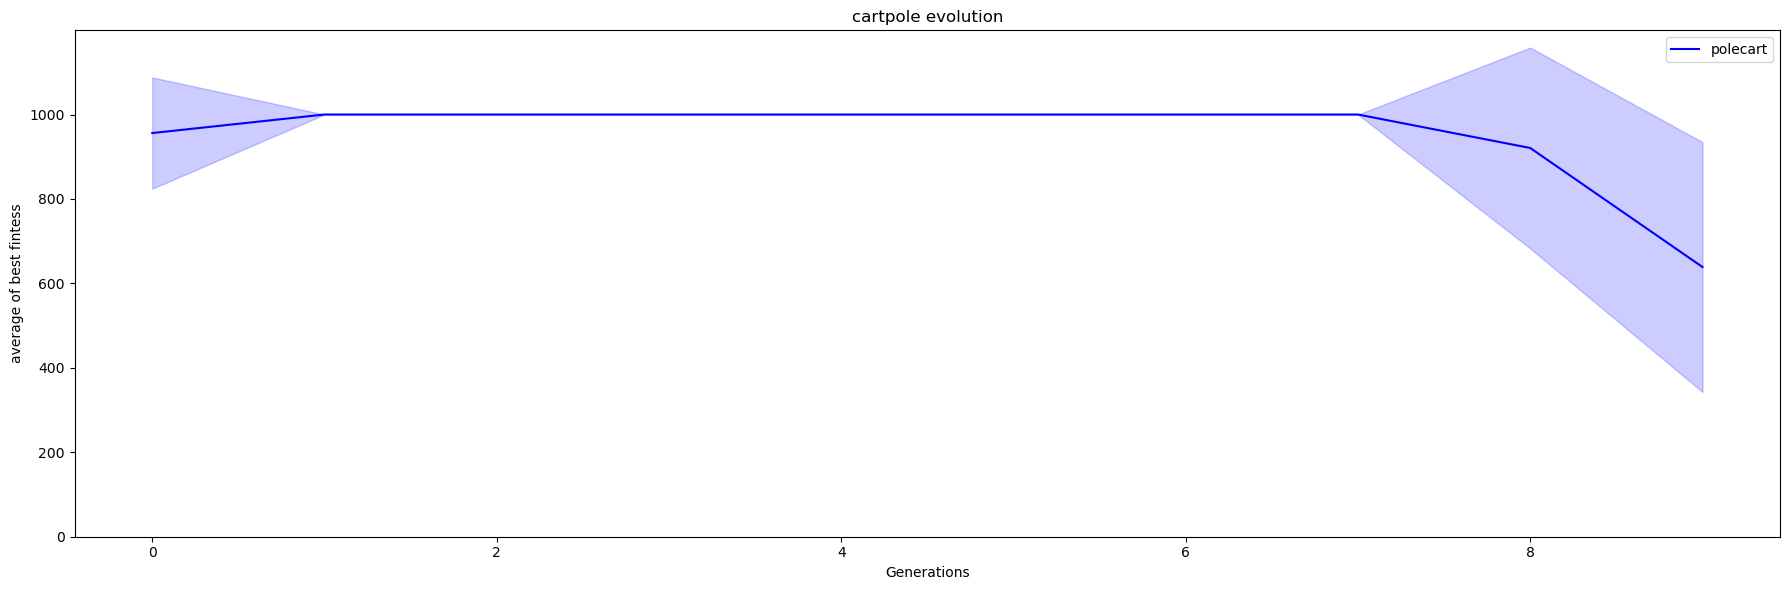

In [10]:

population_size = 300
p_crossover = 0.9
m_rate = 0.1

avgs_experiment_1, stds_experiment_1, all_runs_experiment_1 = run_experiment(population_size,p_crossover,m_rate)

labels = ['cartpole evolution']

generate_plot(avgs_experiment_1,stds_experiment_1,labels,n_columns=1,)